# 0. Environment, Package, Configuration, Seed, CUDA

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import time
import datetime
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
CONFIG = {
    'seed': 42,
    'batch_size': 32,
    'max_len': 128,
    'epochs': 3,
    'lr': 2e-5,
    'eps': 1e-8,
    'warmup_ratio': 0.1,
    'model_name': 'bert-base-multilingual-cased',
    'data_path': 'dataset/YoutubeCommentsDataSet.csv',
}

In [3]:
# Set random seed (Reproducibility)
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(CONFIG['seed'])
print('Set seed to %d.' % CONFIG['seed'])

Set seed to 42.


In [4]:
# check CUDA
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Using the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Using the GPU: NVIDIA GeForce GTX 1060 6GB


# 1. Loading and Preprocessing Data

In [5]:
df = pd.read_csv(CONFIG['data_path'])
print('Number of samples: ', len(df))
df.head()

Number of samples:  18408


,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [6]:
# drop NA
df = df.dropna(subset=['Comment', 'Sentiment'])

# Define label Mapping
label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# convert label
df['label'] = df['Sentiment'].map(label_map)
df = df.dropna(subset=['label']) # remove uncovered label (e.g., 'Other')
df['label'] = df['label'].astype(int)

df.head()

,Comment,Sentiment,label
0,lets not forget that apple pay in 2014 require...,neutral,1
1,here in nz 50 of retailers don’t even have con...,negative,0
2,i will forever acknowledge this channel with t...,positive,2
3,whenever i go to a place that doesn’t take app...,negative,0
4,apple pay is so convenient secure and easy to ...,positive,2


In [7]:
comments = df.Comment.values
labels = df.label.values

In [8]:
print(f"  Effective data rows: {len(df)}")
print(f"  Class distribution: {df['label'].value_counts().to_dict()}")

  Effective data rows: 18364
  Class distribution: {2: 11402, 1: 4625, 0: 2337}


# 2. Tokenization (using Multilingual model)

In [9]:
tokenizer = BertTokenizer.from_pretrained(CONFIG['model_name'])

encoded_batch = tokenizer(
    comments.tolist(),
    add_special_tokens=True,
    max_length=CONFIG['max_len'],
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded_batch['input_ids']
attention_masks = encoded_batch['attention_mask']
labels = torch.tensor(labels)

# 3. Spliting Dataset (with Stratify)

In [10]:
# Convert labels into numpy (for stratify)
labels_np = labels
if torch.is_tensor(labels_np):
    labels_np = labels_np.cpu().numpy()
else:
    labels_np = np.array(labels_np)

all_idx = np.arange(len(labels_np))

# 1) Split 10% for Test index
idx_train_val, idx_test = train_test_split(
    all_idx,
    test_size=0.1,
    random_state=CONFIG['seed'],
    stratify=labels_np
)

# 2) Split 90% left into Train and Val, Val take 10% of total data => 10/90 = 0.1111
idx_train, idx_val = train_test_split(
    idx_train_val,
    test_size=0.1111,
    random_state=CONFIG['seed'],
    stratify=labels_np[idx_train_val]
)

In [11]:
# print the first 5 rows of test data（comments and labels）
for i in idx_test[:5]:
    print(f"\nidx = {i}")
    print("comment :", comments[i])
    print("label:", labels[i])
    print("-" * 60)


idx = 1963
comment : this is the most incredibleunderstandable video on confidence ive came across by far keep it up honestly
label: tensor(2)
------------------------------------------------------------

idx = 3764
comment : jusquà preuve du contraire cest une bonne vidéo
label: tensor(1)
------------------------------------------------------------

idx = 9753
comment : 내 맘도 털렸는데 편의점도 털었네요 편의점 음식이 정말 다양하네요 쯔양님이 하나 하나 소개를 해주니 좋다 쯔양님은 어쩜 이리 귀여울까 말하는것도 먹는것도 다 귀엽네요 귀요미의 끝판왕인가 ㅋㅋ 진구 먼지 소식좀 부탁 재미있게 잘 봤습니다 사랑해요 
label: tensor(1)
------------------------------------------------------------

idx = 1695
comment : to be clear that basketball player 217 did not intentionally bounce that basketball into the hoop he was trying to throw it at the opposing team in order for them to retain the ball by making the ball go out of bounds off i the other player
label: tensor(1)
------------------------------------------------------------

idx = 3503
comment : thanks jason you’ve definitely helped me not f

In [12]:
def index_data(x, idx):
    if torch.is_tensor(x):
        return x[torch.tensor(idx, dtype=torch.long)]
    elif isinstance(x, np.ndarray):
        return x[idx]
    else:
        return [x[i] for i in idx]

In [13]:
# using index distributing data
train_inputs      = index_data(input_ids,       idx_train)
validation_inputs = index_data(input_ids,       idx_val)
test_inputs       = index_data(input_ids,       idx_test)

train_masks       = index_data(attention_masks, idx_train)
validation_masks  = index_data(attention_masks, idx_val)
test_masks        = index_data(attention_masks, idx_test)

train_labels      = index_data(labels,          idx_train)
validation_labels = index_data(labels,          idx_val)
test_labels       = index_data(labels,          idx_test)

print(f"Total: {len(all_idx)}")
print(f"Train: {len(idx_train)} (roughly 80%)")
print(f"Val:   {len(idx_val)}  (roughly 10%)")
print(f"Test:  {len(idx_test)}  (roughly 10%)")

Total: 18364
Train: 14690 (roughly 80%)
Val:   1837  (roughly 10%)
Test:  1837  (roughly 10%)


In [14]:
def clean_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.clone().detach()
    else:
        return torch.tensor(x)

In [15]:
train_inputs = clean_tensor(train_inputs)
validation_inputs = clean_tensor(validation_inputs)
train_masks = clean_tensor(train_masks)
validation_masks = clean_tensor(validation_masks)
train_labels = clean_tensor(train_labels)
validation_labels = clean_tensor(validation_labels)

test_inputs = clean_tensor(test_inputs)
test_masks = clean_tensor(test_masks)
test_labels = clean_tensor(test_labels)

In [16]:
# Building Training DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=CONFIG['batch_size'])

# Building Validation DataLoader
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=CONFIG['batch_size'])

# Building Test DataLoader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=CONFIG['batch_size'])

# 4. Model Initialization

In [17]:
model = BertForSequenceClassification.from_pretrained(
    CONFIG['model_name'], 
    num_labels = 3, 
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], eps=CONFIG['eps'])
total_steps = len(train_dataloader) * CONFIG['epochs']
num_warmup_steps = int(total_steps * CONFIG['warmup_ratio'])
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Training Loop

In [18]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

In [19]:
print("Start Training...")
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, CONFIG['epochs']):
    
    # --- Training ---
    print(f'\n======== Epoch {epoch_i + 1} / {CONFIG["epochs"]} ========')
    t0 = time.time()
    total_train_loss = 0
    model.train()

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch_i+1} Training", leave=False)

    for step, batch in enumerate(progress_bar):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        # Forward Pass
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        total_train_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_train_loss = total_train_loss / len(train_dataloader)         
    training_time = format_time(time.time() - t0)
    print(f"Training Loss: {avg_train_loss:.2f} | Time: {training_time}")

    
    # --- Validation ---
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels, 
                           return_dict=True)

        logits = result.logits
        loss = result.loss
        total_eval_loss += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Compute Accuracy
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        total_eval_accuracy += np.sum(pred_flat == labels_flat) / len(labels_flat)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    val_time = format_time(time.time() - t0)
    print(f"Val Loss: {avg_val_loss:.2f} | Val Accuracy: {avg_val_accuracy:.2f} | Time: {val_time}")

    

print(f"\nTotal Training Time: {format_time(time.time()-total_t0)}")

Start Training...

======== Epoch 1 / 3 ========


Epoch 1 Training:   0%|          | 0/460 [00:00<?, ?it/s]

Training Loss: 0.62 | Time: 0:07:25
Val Loss: 0.47 | Val Accuracy: 0.80 | Time: 0:00:19

======== Epoch 2 / 3 ========


Epoch 2 Training:   0%|          | 0/460 [00:00<?, ?it/s]

Training Loss: 0.38 | Time: 0:07:25
Val Loss: 0.48 | Val Accuracy: 0.80 | Time: 0:00:20

======== Epoch 3 / 3 ========


Epoch 3 Training:   0%|          | 0/460 [00:00<?, ?it/s]

Training Loss: 0.25 | Time: 0:07:25
Val Loss: 0.50 | Val Accuracy: 0.82 | Time: 0:00:20

Total Training Time: 0:23:14


# 6. Test Set Evaluation

In [20]:
print("\nRunning Final Test Set Evaluation...")

model.eval()
test_preds = []
test_true_labels = []

for batch in tqdm(test_dataloader, desc="Testing"):
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    with torch.no_grad():        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

    logits = result.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 收集結果
    test_preds.extend(np.argmax(logits, axis=1).flatten())
    test_true_labels.extend(label_ids.flatten())

# 計算最終準確度
final_accuracy = accuracy_score(test_true_labels, test_preds)
print(f"Test Accuracy: {final_accuracy:.2f}")

print("\nTest Set Classification Report:")
print(classification_report(test_true_labels, test_preds, target_names=['Negative', 'Neutral', 'Positive']))


Running Final Test Set Evaluation...


Testing:   0%|          | 0/58 [00:00<?, ?it/s]

Test Accuracy: 0.82

Test Set Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.69      0.70       234
     Neutral       0.70      0.69      0.69       463
    Positive       0.89      0.91      0.90      1140

    accuracy                           0.82      1837
   macro avg       0.77      0.76      0.77      1837
weighted avg       0.82      0.82      0.82      1837



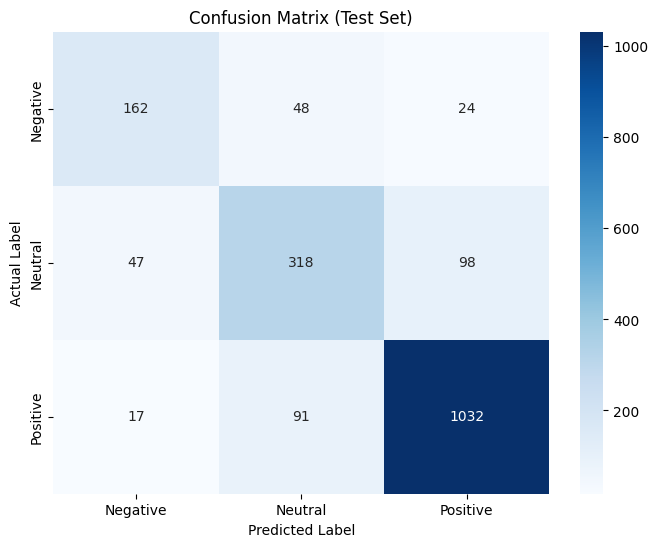

In [21]:
cm = confusion_matrix(test_true_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

In [25]:
# === Saving the prediction on Test set into CSV ===

X_test = comments[idx_test]
y_test = labels_np[idx_test] 

# make sure X_test / y_test and test_preds have same len
print("len(X_test):", len(X_test))
print("len(y_test):", len(y_test))
print("len(test_preds):", len(test_preds))

results_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": test_preds
})

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
results_df["true_label_str"] = results_df["true_label"].map(label_map)
results_df["pred_label_str"] = results_df["pred_label"].map(label_map)

# Save as CS
output_path = "outputs/bert/test_predictions.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
results_df.to_csv(output_path, index=False)
print(f"Saved: {output_path}")
results_df.head()

len(X_test): 1837
len(y_test): 1837
len(test_preds): 1837
Saved: outputs/bert/test_predictions.csv


,text,true_label,pred_label,true_label_str,pred_label_str
0,this is the most incredibleunderstandable vide...,2,2,Positive,Positive
1,jusquà preuve du contraire cest une bonne vidéo,1,1,Neutral,Neutral
2,내 맘도 털렸는데 편의점도 털었네요 편의점 음식이 정말 다양하네요 쯔양님이 하나 하...,1,1,Neutral,Neutral
3,to be clear that basketball player 217 did not...,1,1,Neutral,Neutral
4,thanks jason you’ve definitely helped me not f...,2,2,Positive,Positive
